
# 04_generate_monthly.ipynb
This notebook uses the **SILVER** dataset (`maroc_energy_weather_1990_2023.csv`) to create a realistic **monthly** dataset for Morocco (2000–2023).  
It preserves trends (fossil ↓, renewables ↑), adds seasonality via temperature, and **rescales** to national yearly totals (approximate ONEE trend).


In [9]:
# --- Config
import pandas as pd
import numpy as np
from pathlib import Path

# Go up from notebooks/ to project root, then into data/
BASE = Path('..')
DATA_DIR = BASE / 'data'
SILVER = DATA_DIR / 'silver' / 'maroc_energy_weather_1990_2023.csv'
GOLD_OUT = DATA_DIR / 'gold' / 'maroc_monthly_2000_2023.csv'

# Create folders if they don't exist (idempotent)
GOLD_OUT.parent.mkdir(parents=True, exist_ok=True)

print("✅ Paths configured successfully:")
print("SILVER path:", SILVER.resolve())
print("GOLD out   :", GOLD_OUT.resolve())

# --- Load SILVER (annual) ---
df = pd.read_csv(SILVER)

# Try to standardize expected columns
col_map_candidates = {
    'year': ['year', 'annee', 'Année', 'Annee'],
    'fossil_pct': ['fossil_pct', 'valeur_fossiles', 'fossiles_pct', 'mix_fossiles_pct'],
    'oil_pct': ['oil_pct', 'valeur_petrole', 'petrole_pct'],
    'renewables_kWh': ['renewables_kWh', 'valeur_renouvhx', 'renouvelables_kwh', 'renouvelables'],
    'temperature': ['temperature', 'temp', 't', 'temp_moy']
}

rename_map = {}
for expected, options in col_map_candidates.items():
    for opt in options:
        if opt in df.columns:
            rename_map[opt] = expected
            break

df = df.rename(columns=rename_map)

missing = [c for c in ['year', 'fossil_pct', 'oil_pct', 'renewables_kWh', 'temperature'] if c not in df.columns]
if missing:
    raise ValueError(f"❌ Missing columns after rename: {missing}. Please update the mapping above to match your SILVER file.")

# Filter by year
df = df[(df['year'] >= 1990) & (df['year'] <= 2023)].sort_values('year').reset_index(drop=True)
print("✅ Data loaded successfully:", df.shape)
df.tail()


✅ Paths configured successfully:
SILVER path: C:\Users\HP\bigdata-electricity\data\silver\maroc_energy_weather_1990_2023.csv
GOLD out   : C:\Users\HP\bigdata-electricity\data\gold\maroc_monthly_2000_2023.csv
✅ Data loaded successfully: (34, 8)


,indicateur_fossiles,year,fossil_pct,indicateur_petrole,oil_pct,indicateur_renouvhx,renewables_kWh,temperature
29,Production d'électricité à partir des sources ...,2019,77.762305,Production d’électricité à partir de sources p...,1.901561,Production d’électricité à partir de sources d...,6.364250e+09,18.27
30,Production d'électricité à partir des sources ...,2020,78.270421,Production d’électricité à partir de sources p...,1.720092,Production d’électricité à partir de sources d...,6.194710e+09,18.72
31,Production d'électricité à partir des sources ...,2021,77.815371,Production d’électricité à partir de sources p...,3.230657,Production d’électricité à partir de sources d...,7.010430e+09,18.51
32,Production d'électricité à partir des sources ...,2022,79.434483,Production d’électricité à partir de sources p...,9.798230,NaN,NaN,19.15
33,Production d'électricité à partir des sources ...,2023,76.033493,Production d’électricité à partir de sources p...,4.182014,NaN,NaN,19.16


In [10]:

# --- Define national yearly totals (GWh) to match (approximate Morocco trend) ---
# You can tweak these anchors.
target_yearly = {
    2000: 15000,
    2010: 25000,
    2020: 35000,
    2023: 40000,
}

def interpolate_yearly_target(year:int, anchors:dict):
    years = sorted(anchors.keys())
    vals = [anchors[y] for y in years]
    return float(np.interp(year, years, vals))

# Sanity check
[ (y, interpolate_yearly_target(y, target_yearly)) for y in [2000,2005,2010,2015,2020,2023] ]


[(2000, 15000.0),
 (2005, 20000.0),
 (2010, 25000.0),
 (2015, 30000.0),
 (2020, 35000.0),
 (2023, 40000.0)]

In [11]:

# --- Generate realistic monthly data ---
np.random.seed(42)

years = np.arange(2000, 2024)
months = np.arange(1, 13)

rows = []

# Build quick dicts from annual SILVER values (forward/backward fill to avoid gaps)
annual = df.set_index('year')[['fossil_pct','oil_pct','renewables_kWh','temperature']].sort_index()
annual = annual.reindex(np.arange(1990, 2024)).interpolate().ffill().bfill()

for year in years:
    base_fossil = annual.loc[year, 'fossil_pct'] + np.random.uniform(-1, 1)
    base_oil = annual.loc[year, 'oil_pct'] + np.random.uniform(-0.5, 0.5)
    base_renew = annual.loc[year, 'renewables_kWh'] + np.random.uniform(-5e6, 5e6)
    base_temp = annual.loc[year, 'temperature'] + np.random.uniform(-0.2, 0.2)

    # First pass: build monthly with temperature seasonality
    monthly_vals = []
    month_rows = []
    for m in months:
        # Seasonality via temperature sine wave
        temp = base_temp + 3 * np.sin((m - 1) / 12 * 2 * np.pi)
        fossil = base_fossil + np.random.uniform(-1.5, 1.5)
        oil = base_oil + np.random.uniform(-1, 1)
        renew = base_renew * (1 + np.random.uniform(-0.05, 0.05))

        # Synthetic base consumption (GWh) before scaling
        elec = (
            1200
            + (19 - temp) * -60   # warmer -> more cooling demand
            + fossil * 30
            + renew / 1e8
            + np.random.uniform(-100, 100)
        )
        monthly_vals.append(elec)
        month_rows.append([year, m, fossil, oil, renew, round(temp,2), elec])

    # Scale monthly values to hit the national yearly total
    target = interpolate_yearly_target(year, target_yearly)
    monthly_vals = np.array(monthly_vals)
    scale = target / monthly_vals.sum()
    for i in range(12):
        month_rows[i][6] = round(monthly_vals[i] * scale, 2)

    rows.extend(month_rows)

monthly = pd.DataFrame(rows, columns=[
    'year','month','fossil_pct','oil_pct','renewables_kWh','temperature','electricity_consumption_GWh'
])

monthly.head(), monthly.tail(), monthly.shape


(   year  month  fossil_pct    oil_pct  renewables_kWh  temperature  \
 0  2000      1   92.637683  25.402134    6.400087e+07        18.02   
 1  2000      2   93.972973  26.506290    6.374978e+07        19.52   
 2  2000      3   94.666955  25.514823    6.482944e+07        20.62   
 3  2000      4   93.082354  26.139658    6.650424e+07        21.02   
 4  2000      5   94.005186  25.369133    6.556814e+07        20.62   
 
    electricity_consumption_GWh  
 0                      1261.78  
 1                      1309.42  
 2                      1287.12  
 3                      1286.54  
 4                      1292.41  ,
      year  month  fossil_pct   oil_pct  renewables_kWh  temperature  \
 283  2023      8   78.432404  4.469560    7.289305e+09        17.51   
 284  2023      9   76.119785  3.713160    7.119289e+09        16.41   
 285  2023     10   78.073545  4.597311    7.341267e+09        16.01   
 286  2023     11   78.086340  5.204085    7.202922e+09        16.41   
 287  2

In [12]:

# --- Save to GOLD
monthly.to_csv(GOLD_OUT, index=False)
print('Saved:', GOLD_OUT.resolve())
monthly.groupby('year')['electricity_consumption_GWh'].sum().head()


Saved: C:\Users\HP\bigdata-electricity\data\gold\maroc_monthly_2000_2023.csv


year
2000    15000.01
2001    16000.01
2002    16999.99
2003    17999.99
2004    19000.01
Name: electricity_consumption_GWh, dtype: float64

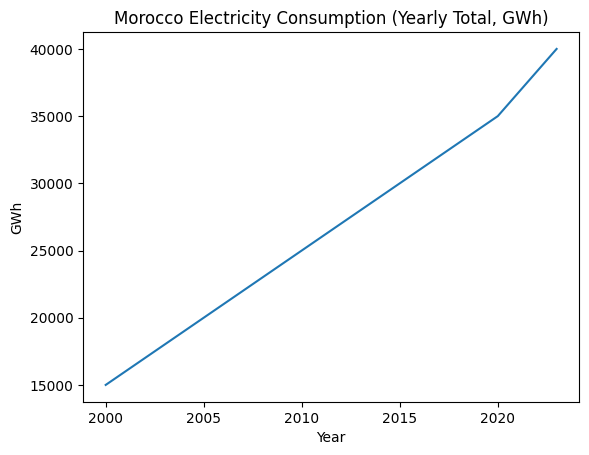

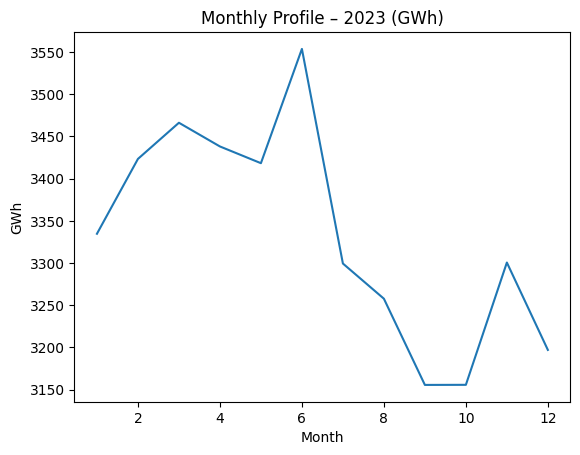

In [ ]:

# --- Quick sanity checks/visuals ---
import matplotlib.pyplot as plt

# Yearly totals trend
yearly = monthly.groupby('year')['electricity_consumption_GWh'].sum()

plt.figure()
yearly.plot(title='Morocco Electricity Consumption (Yearly Total, GWh)')
plt.xlabel('Year'); plt.ylabel('GWh')
plt.show()

# Seasonality pattern in a recent year
sample = monthly[monthly['year']==2023].copy()
plt.figure()
plt.plot(sample['month'], sample['electricity_consumption_GWh'])
plt.title('Monthly Profile – 2023 (GWh)')
plt.xlabel('Month'); plt.ylabel('GWh')
plt.show()
